###  9.2 最初のグラフの作成とセッション内での実行

In [1]:
import tensorflow as tf

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

x = tf.Variable(3,name="x")
y = tf.Variable(4,name="y") 
f = x*x*y + y + 2

/Users/home/.pyenv/versions/3.6.3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)
sess.close()

42


In [3]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()
    print(result)

42


In [4]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run() #すべての変数を初期化
    result = f.eval()

In [5]:
#Jupyterではtf.Session()の代わりにtf.InteractiveSession()を使った方が良い

### 9.3 グラフの管理

In [6]:
#作成されるグラフは自動的にデフォルトグラフに追加される
x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

In [7]:
#独立した複数のグラフを管理したい時
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)
    
print(x2.graph is graph)
print(x2.graph is tf.get_default_graph)

True
False


### 9.4 ノードの値のライフサイクル

In [8]:
w = tf.constant(3)
x = w +2
y = x+5
z = x * 3

with tf.Session() as sess:
    print(y.eval())
    print(z.eval())
    # 評価が行われると変数以外は捨てられる

10
15


In [9]:
with tf.Session() as sess:
    y_val, z_val = sess.run([y,z])
    print(y_val)
    print(z_val)

10
15


### 9.5 TensorFlowによる線形回帰

In [10]:
import numpy as np
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m,1)), housing.data]

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1,1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT),y)

with tf.Session() as sess:
    theta_value = theta.eval()
    
theta_value

array([[-3.6953510e+01],
       [ 4.3662700e-01],
       [ 9.4335107e-03],
       [-1.0715115e-01],
       [ 6.4466727e-01],
       [-3.9508177e-06],
       [-3.7860589e-03],
       [-4.2133558e-01],
       [-4.3463427e-01]], dtype=float32)

### 9.6 勾配降下法の実装

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m,1)), scaled_housing_data]

In [12]:
n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1,1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0,1.0), name='theta')
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta-learning_rate*gradients)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("epoch:{}, MSE:{}".format(epoch, mse.eval()))
        sess.run(training_op)
        
    best_theta = theta.eval()

epoch:0, MSE:7.2630133628845215
epoch:100, MSE:0.9154175519943237
epoch:200, MSE:0.7329704761505127
epoch:300, MSE:0.6756102442741394
epoch:400, MSE:0.6368359923362732
epoch:500, MSE:0.6084683537483215
epoch:600, MSE:0.5875192284584045
epoch:700, MSE:0.5719916820526123
epoch:800, MSE:0.5604439377784729
epoch:900, MSE:0.5518249869346619


In [13]:
best_theta

array([[ 2.0685523 ],
       [ 0.8720661 ],
       [ 0.1698142 ],
       [-0.2651011 ],
       [ 0.26988778],
       [ 0.01352099],
       [-0.04455061],
       [-0.48778564],
       [-0.459481  ]], dtype=float32)

In [14]:
n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1,1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0,1.0), name='theta')
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("epoch:{}, MSE:{}".format(epoch, mse.eval()))
        sess.run(training_op)
        
    best_theta = theta.eval()

epoch:0, MSE:10.552412033081055
epoch:100, MSE:0.7003449201583862
epoch:200, MSE:0.5374404191970825
epoch:300, MSE:0.5317783951759338
epoch:400, MSE:0.5297033190727234
epoch:500, MSE:0.5282396078109741
epoch:600, MSE:0.527178943157196
epoch:700, MSE:0.5264082551002502
epoch:800, MSE:0.5258487462997437
epoch:900, MSE:0.5254408121109009


In [15]:
best_theta

array([[ 2.0685525e+00],
       [ 8.2585591e-01],
       [ 1.2854016e-01],
       [-2.3878908e-01],
       [ 2.7495486e-01],
       [-8.9305459e-04],
       [-4.0074110e-02],
       [-8.3206624e-01],
       [-8.0133408e-01]], dtype=float32)

### 9.7 訓練アルゴリズムへのデータ供給

In [16]:
A = tf.placeholder(dtype=tf.float32, shape=(None, 3))
B = A + 5

with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A:[[1,2,3]]})
    B_val_2 = B.eval(feed_dict={A:[[4,5,6], [7,8,9]]})
print(B_val_1)
print(B_val_2)

[[6. 7. 8.]]
[[ 9. 10. 11.]
 [12. 13. 14.]]


In [17]:
n_epochs = 1000
learning_rate = 0.01
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

X = tf.placeholder(dtype=tf.float32, shape=(None, n+1),name='X')
y = tf.placeholder(dtype=tf.float32, shape=(None, 1), name='y')

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0,seed=42), name='theta')
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()


def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)
    indice = np.random.randint(m,size=batch_size)
    X_batch = scaled_housing_data_plus_bias[indice]
    y_batch = housing.target.reshape(-1,1)[indice]
    return X_batch, y_batch

n_epochs = int(n_epochs/batch_size)

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        
        
    best_theta = theta.eval()
best_theta

array([[ 2.070016  ],
       [ 0.8204561 ],
       [ 0.11731727],
       [-0.22739054],
       [ 0.31134024],
       [ 0.00353192],
       [-0.01126995],
       [-0.9164394 ],
       [-0.87950087]], dtype=float32)

### 9.8 モデルの保存と復元

In [18]:
reset_graph()
n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1,1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0,1.0,seed=42), name='theta')
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("epoch:{}, MSE:{}".format(epoch, mse.eval()))
            save_path = saver.save(sess, 'resource/model.ckpt')
        sess.run(training_op)
        
    best_theta = theta.eval()
    save_path = saver.save(sess, 'resource/final_model.ckpt')

epoch:0, MSE:9.161542892456055
epoch:100, MSE:0.7145006060600281
epoch:200, MSE:0.5667049884796143
epoch:300, MSE:0.5555717945098877
epoch:400, MSE:0.5488112568855286
epoch:500, MSE:0.5436362028121948
epoch:600, MSE:0.539629340171814
epoch:700, MSE:0.5365092158317566
epoch:800, MSE:0.5340678095817566
epoch:900, MSE:0.5321474671363831


In [19]:
best_theta

array([[ 2.0685525 ],
       [ 0.8874027 ],
       [ 0.1440166 ],
       [-0.34770876],
       [ 0.36178362],
       [ 0.00393811],
       [-0.04269556],
       [-0.6614528 ],
       [-0.6375277 ]], dtype=float32)

In [20]:
with tf.Session() as sess:
    saver.restore(sess,'resource/final_model.ckpt')
    best_theta = theta.eval()

In [21]:
best_theta

array([[ 2.0685525 ],
       [ 0.8874027 ],
       [ 0.1440166 ],
       [-0.34770876],
       [ 0.36178362],
       [ 0.00393811],
       [-0.04269556],
       [-0.6614528 ],
       [-0.6375277 ]], dtype=float32)

In [22]:
reset_graph()

saver = tf.train.import_meta_graph('resource/final_model.ckpt.meta')
theta = tf.get_default_graph().get_tensor_by_name("theta:0")

with tf.Session() as sess:
    saver.restore(sess, 'resource/final_model.ckpt')
    best_theta_restored = theta.eval()

In [23]:
best_theta_restored

array([[ 2.0685525 ],
       [ 0.8874027 ],
       [ 0.1440166 ],
       [-0.34770876],
       [ 0.36178362],
       [ 0.00393811],
       [-0.04269556],
       [-0.6614528 ],
       [-0.6375277 ]], dtype=float32)

### 9.9 TensorBoardを使ったグラフと訓練曲線の可視化

In [24]:
reset_graph()
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)
    indice = np.random.randint(m,size=batch_size)
    X_batch = scaled_housing_data_plus_bias[indice]
    y_batch = housing.target.reshape(-1,1)[indice]
    return X_batch, y_batch

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}".format(root_logdir, now)

n_epochs = 1000
learning_rate = 0.01
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

X = tf.placeholder(dtype=tf.float32, shape=(None, n+1),name='X')
y = tf.placeholder(dtype=tf.float32, shape=(None, 1), name='y')
theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0,1.0,seed=42), name='theta')
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)
mse_summary = tf.summary.scalar('MSE',mse)
file_writer = tf.summary.FileWriter(logdir, graph=tf.get_default_graph())

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = int(n_epochs/batch_size)

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval (feed_dict={X:X_batch, y:y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        
        
    best_theta = theta.eval()

file_writer.close()

In [25]:
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255152],
       [-0.31211886],
       [ 0.38510385],
       [ 0.00434168],
       [-0.01232954],
       [-0.83376884],
       [-0.803047  ]], dtype=float32)

### 9.10 名前スコープ

In [26]:
reset_graph()
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)
    indice = np.random.randint(m,size=batch_size)
    X_batch = scaled_housing_data_plus_bias[indice]
    y_batch = housing.target.reshape(-1,1)[indice]
    return X_batch, y_batch

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}".format(root_logdir, now)

n_epochs = 1000
learning_rate = 0.01
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

X = tf.placeholder(dtype=tf.float32, shape=(None, n+1),name='X')
y = tf.placeholder(dtype=tf.float32, shape=(None, 1), name='y')
theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0,1.0,seed=42), name='theta')
y_pred = tf.matmul(X, theta, name="predictions")
with tf.name_scope("loss") as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)
mse_summary = tf.summary.scalar('MSE',mse)
file_writer = tf.summary.FileWriter(logdir, graph=tf.get_default_graph())

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = int(n_epochs/batch_size)

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval (feed_dict={X:X_batch, y:y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        
        
    best_theta = theta.eval()

file_writer.close()

### 9.11 モジュール性

In [27]:
reset_graph()
def relu(X):
    w_shape = (int(X.get_shape()[1]),1)
    w = tf.Variable(tf.random_normal(w_shape), name='weights')
    b = tf.Variable(0.0, name='bias')
    z = tf.add(tf.matmul(w,X), b, name='z')
    return tf.maximum(z, 0, name='relu')

n_features = 3
X = tf.placeholder(dtype=tf.float32,shape=(None, n_features),name='X')
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus,name='output')

In [28]:
file_writer = tf.summary.FileWriter("logs/relu1", tf.get_default_graph())

In [29]:
reset_graph()
def relu(X):
    with tf.name_scope('relu') as scope:
        w_shape = (int(X.get_shape()[1]),1)
        w = tf.Variable(tf.random_normal(w_shape), name='weights')
        b = tf.Variable(0.0, name='bias')
        z = tf.add(tf.matmul(w,X), b, name='z')
        return tf.maximum(z, 0, name='relu')

n_features = 3
X = tf.placeholder(dtype=tf.float32,shape=(None, n_features),name='X')
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus,name='output')

In [30]:
file_writer = tf.summary.FileWriter("logs/relu2", tf.get_default_graph())

### 9.12 変数の共有

In [31]:
def relu(X,threshold):
    with tf.name_scope('relu') as scope:
        w_shape = (int(X.get_shape()[1]),1)
        w = tf.Variable(tf.random_normal(w_shape), name='weights')
        b = tf.Variable(0.0, name='bias')
        z = tf.add(tf.matmul(w,X), b, name='z')
        return tf.maximum(z, threshold, name='max')
    
threshold = tf.Variable(0.0,name='threshold')
X = tf.placeholder(tf.float32, shape=(None, n_features), name='X')
relus = [relu(X, threshold) for i in range(5)]
output = tf.add_n(relus, name='output')

In [33]:
reset_graph()

def relu(X):
    with tf.name_scope('relu') as scope:
        if not hasattr(relu, 'threshold'):
            relu.threshold = tf.Variable(0.0, name='threshold')
        w_shape = (int(X.get_shape()[1]),1)
        w = tf.Variable(tf.random_normal(w_shape), name='weights')
        b = tf.Variable(0.0, name='bias')
        z = tf.add(tf.matmul(w,X), b, name='z')
        return tf.maximum(z, relu.threshold, name='max')

In [34]:
with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))

In [35]:
with tf.variable_scope("relu", reuse=True):
    threshold = tf.get_variable("threshold")

In [42]:
reset_graph()

def relu(X):
    with tf.variable_scope("relu",reuse=True):
        threshold = tf.get_variable("threshold")
        w_shape = (int(X.get_shape()[1]),1)
        w = tf.Variable(tf.random_normal(w_shape), name='weights')
        b = tf.Variable(0.0, name='bias')
        z = tf.add(tf.matmul(w,X), b, name='z')
        return tf.maximum(z, threshold, name='max')
    
X = tf.placeholder(tf.float32, shape=(None, n_features),name='X')
with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

In [43]:
file_writer = tf.summary.FileWriter("logs/relu3", tf.get_default_graph())
file_writer.close()

In [44]:
reset_graph()

def relu(X):
    threshold = tf.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))
    w_shape = (int(X.get_shape()[1]),1)
    w = tf.Variable(tf.random_normal(w_shape), name='weights')
    b = tf.Variable(0.0, name='bias')
    z = tf.add(tf.matmul(w,X), b, name='z')
    return tf.maximum(z, threshold, name='max')

X = tf.placeholder(tf.float32,shape=(None, n_features), name="X")
relus = []
for i in range(5):
    with tf.variable_scope("relu", reuse=(i >= 1 or None)) as scope:
        relus.append(relu(X))
        
output = tf.add_n(relus)

In [45]:
file_writer = tf.summary.FileWriter("logs/relu4", tf.get_default_graph())
file_writer.close()

### 9.13 演習問題


In [47]:
from sklearn.datasets import make_moons
m = 1000
X_moons, y_moons = make_moons(n_samples=m,noise=0.1, random_state=42)

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

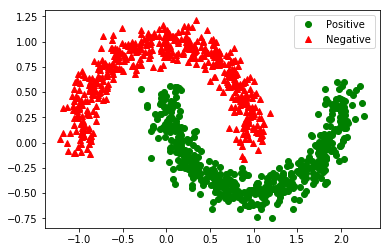

In [50]:
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

In [52]:
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]
X_moons_with_bias[:5]

array([[ 1.        , -0.05146968,  0.44419863],
       [ 1.        ,  1.03201691, -0.41974116],
       [ 1.        ,  0.86789186, -0.25482711],
       [ 1.        ,  0.288851  , -0.44866862],
       [ 1.        , -0.83343911,  0.53505665]])

In [55]:
y_moons_column_vector = y_moons.reshape(-1,1)

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_moons_with_bias, y_moons_column_vector, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import KFold
